In [262]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Считываем данные

In [263]:
data = pd.read_csv('ELDORADO.csv')
data_frame = data.ix[ : , : -1]
target_variable = data.ix[ : , -1]

In [264]:
print(data.shape)
data[:5]

(2100, 18)


,employee_id,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,fired
0,957099050466813076,3529,500934542,3012,378,1557,4091,167,0,30,16697818,0,141948,10,38,5,0,0
1,13164358679111999796,2017,490702594,1958,453,1238,2548,185,0,30,16356753,0,243283,22,48,9,0,0
2,5442250097157630866,169,43802030,162,28,0,189,8,0,30,1460067,0,259183,16,0,4,0,0
3,9345017131298737624,844,201061365,781,256,172,928,42,0,30,6702045,0,238224,30,18,5,0,0
4,6389462342858680146,213,95858986,197,46,0,391,10,0,30,3195299,0,450042,21,0,5,0,0


Итак, мы имеем 2100 объектов, при этом 94 из них размечены единицами (4.5%), остальные - нулями.

При более детальном изучении данных, можно заметить, что факторы 8 и 16 связаны: равны 0 или больше 0 одновременно. 

Если фактор 8 (или 16) положителен, то в 27 случаях из 29 объект размечается единицей. 
    (Если бы данных было больше, это могло бы дать основание написать разные классификаторы 
     для объектов с нулевым и положительным фактором 8)

По внешнему виду факторов можно сделать некоторые выводы: 
    фактор 9 похож на дату, факторы  13, 14, 15 похожи на проценты,
    факторы 11 и 16, скорее всего, являются категориальными признаками.

Отсутствие знаний про природу признаков (трудно придумать адекватную метрику), 
    а также вероятное наличие среди них категориальных признаков делает применение метрических классификаторов 
    нецелесообразным. Поэтому будем пользоваться древесными алгоритмами и их ансамблями.

Введем новый категориальный признак: 1, если 16-ый признак положительный, 0 - иначе.

In [265]:
new_factor_17 = pd.DataFrame([1 if item > 0 else 0 for item in data_frame.ix[ : , 16]], columns = ['new_factor_17'])

Присоединим его к нашим старым признакам

In [266]:
new_data_frame = pd.DataFrame(np.c_[data_frame, new_feature_17], 
                              columns = np.append(data_frame.columns.values, new_factor_17.columns.values))

In [267]:
new_data_frame[:5]

,employee_id,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,new_factor_17
0,957099050466813076,3529,500934542,3012,378,1557,4091,167,0,30,16697818,0,141948,10,38,5,0,0
1,13164358679111999796,2017,490702594,1958,453,1238,2548,185,0,30,16356753,0,243283,22,48,9,0,0
2,5442250097157630866,169,43802030,162,28,0,189,8,0,30,1460067,0,259183,16,0,4,0,0
3,9345017131298737624,844,201061365,781,256,172,928,42,0,30,6702045,0,238224,30,18,5,0,0
4,6389462342858680146,213,95858986,197,46,0,391,10,0,30,3195299,0,450042,21,0,5,0,0


Исключим 'employee_id' из числа наших признаков

In [268]:
small_data_frame = data_frame.ix[ : , 1 : ]

Построим дерево решений, оптимизируя его максимальную глубину

In [269]:
grid_searcher_dt = GridSearchCV(DecisionTreeClassifier(criterion='gini'), 
                              {'max_depth': np.arange(1, 500)}, cv=5, scoring='roc_auc', n_jobs=4)
grid_searcher_dt.fit(small_data_frame, target_variable)

print(grid_searcher_dt.best_score_)
print(grid_searcher_dt.best_estimator_)

0.955714838371
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')


Построим случайный лес, оптимизируя количество деревьев в нем 
(хотя количество деревьев можно и дальше наращивать (вопрос времени окончания рассчетов), это не приведет к переобучению).

In [270]:
grid_searcher_rf = GridSearchCV(RandomForestClassifier(criterion='entropy'), 
                              {'n_estimators': np.arange(1, 1000, 5)}, cv=5, scoring='roc_auc', n_jobs=4)
grid_searcher_rf.fit(small_data_frame, target_variable)

print(grid_searcher_rf.best_score_)
print(grid_searcher_rf.best_estimator_)

0.996648844701
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=346, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Качество классификации подросло, что и было ожидаемо, 
так как ансамбль алгоритмов работает лучше, чем его отдельные представители.

Качество классификатора оценивалось процедурой 5-fold cross-validation, мерой качества был выбран показатель AUC.

Визуализируем качество моделей в зависимости от параметров

In [271]:
def plot_quality(gridSearcher, paramName):
    means = []
    stds = []
    for elem in gridSearcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)

    params = gridSearcher.param_grid

    plt.figure(figsize=(8, 6))
    plt.plot(params[paramName], means)
    plt.fill_between(params[paramName], means + stds, means - stds, alpha=0.3, facecolor='blue')
    plt.xlabel(paramName)
    plt.ylabel('AUC')

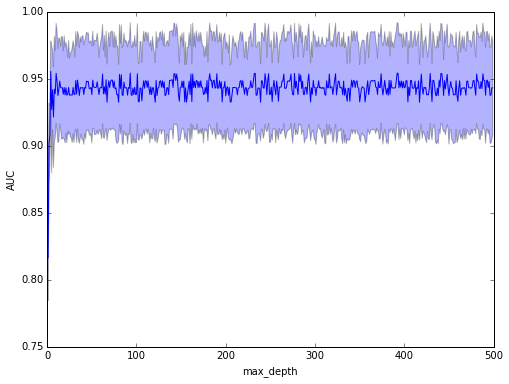

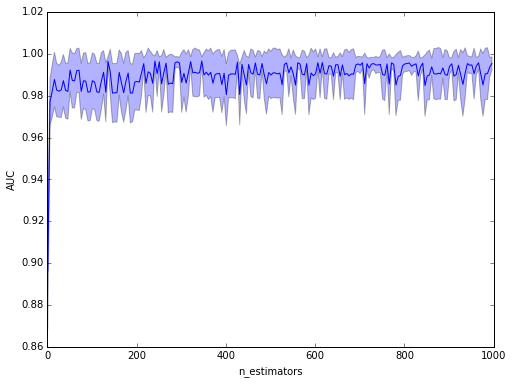

In [272]:
plot_quality(grid_searcher_dt, 'max_depth')
plot_quality(grid_searcher_rf, 'n_estimators')

Выясним степень важности признаков нашего классификатора 

In [273]:
importances = grid_searcher_rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_searcher_rf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)):
    print("%d. feature %d (%f)" % (f + 1, indices[f] + 1, importances[indices[f]]))

Feature ranking:
1. feature 13 (0.265260)
2. feature 15 (0.258360)
3. feature 11 (0.098770)
4. feature 12 (0.087454)
5. feature 9 (0.045941)
6. feature 14 (0.034822)
7. feature 8 (0.032303)
8. feature 16 (0.028635)
9. feature 7 (0.028054)
10. feature 3 (0.021931)
11. feature 10 (0.021153)
12. feature 1 (0.018582)
13. feature 2 (0.015372)
14. feature 4 (0.014786)
15. feature 5 (0.014327)
16. feature 6 (0.014252)
